<a href="https://colab.research.google.com/github/leovegamedina/projects-ml/blob/main/Titanic_Kmeans_MLCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo K-Means

## 1. Descripción del dataset.


Como primer paso, haremos las importaciones de los packages a utilizar y además **nos** traeremos el dataset de Titanic que actualmente tenemos en .xlsx a un dataframe utilizando Pandas.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Projects/Unsupervised MLA/K-Means'

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

titanic_org = pd.read_excel(root_path + '/' + 'Titanic.xlsx')

In [ ]:
titanic_org.head()

,Name,Passenger Class,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Passenger Fare,Port of Embarkation,Life Boat,Survived
0,"Allen, Miss. Elisabeth Walton",First,Female,29.0000,0,0,211.3375,Southampton,2,Yes
1,"Allison, Master. Hudson Trevor",First,Male,0.9167,1,2,151.5500,Southampton,11,Yes
2,"Allison, Miss. Helen Loraine",First,Female,2.0000,1,2,151.5500,Southampton,NaN,No
3,"Allison, Mr. Hudson Joshua Creighton",First,Male,30.0000,1,2,151.5500,Southampton,NaN,No
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",First,Female,25.0000,1,2,151.5500,Southampton,NaN,No


Por un tema de orden en el dataset, cambiaremos los nombres de las columnas para que puedan ser mas legibles.

In [ ]:
new_names = {'Name':'name','Passenger Class':'pass_class','Sex':'sex','Age':'age','No of Siblings or Spouses on Board':'no_sib_spo_ob','No of Parents or Children on Board':'no_par_chld_ob','Passenger Fare':'pass_fare','Port of Embarkation':'port_emb','Life Boat':'life_boat','Survived':'survived'}

## Reemplazamos los nombres de las columnas con la nueva definción de nuestro diccionario.

titanic_org = titanic_org.rename(columns=new_names)
titanic_org.head()

,name,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,port_emb,life_boat,survived
0,"Allen, Miss. Elisabeth Walton",First,Female,29.0000,0,0,211.3375,Southampton,2,Yes
1,"Allison, Master. Hudson Trevor",First,Male,0.9167,1,2,151.5500,Southampton,11,Yes
2,"Allison, Miss. Helen Loraine",First,Female,2.0000,1,2,151.5500,Southampton,NaN,No
3,"Allison, Mr. Hudson Joshua Creighton",First,Male,30.0000,1,2,151.5500,Southampton,NaN,No
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",First,Female,25.0000,1,2,151.5500,Southampton,NaN,No


Guardaremos una copia de este dataset con la que haremos todo el desarrollo de nuestro modelo de clustering.

In [ ]:
## Guardamos titanic_orig en un nuevo dataframe titanic_dev

titanic_dev = titanic_org
titanic_dev.head()

,name,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,port_emb,life_boat,survived
0,"Allen, Miss. Elisabeth Walton",First,Female,29.0000,0,0,211.3375,Southampton,2,Yes
1,"Allison, Master. Hudson Trevor",First,Male,0.9167,1,2,151.5500,Southampton,11,Yes
2,"Allison, Miss. Helen Loraine",First,Female,2.0000,1,2,151.5500,Southampton,NaN,No
3,"Allison, Mr. Hudson Joshua Creighton",First,Male,30.0000,1,2,151.5500,Southampton,NaN,No
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",First,Female,25.0000,1,2,151.5500,Southampton,NaN,No


Antes de continuar, haremos una descripción de nuestro dataset para ver con que información contamos para desarrollar nuestro modelo de clustering.

In [ ]:
titanic_org.describe(include='all')

,name,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,port_emb,life_boat,survived
count,1307,1307,1307,1044.000000,1307.000000,1307.000000,1306.000000,1305,486,1307
unique,1307,3,2,NaN,NaN,NaN,NaN,3,27,2
top,"Molson, Mr. Harry Markland",Third,Male,NaN,NaN,NaN,NaN,Southampton,13,No
freq,1,707,842,NaN,NaN,NaN,NaN,913,39,807
mean,NaN,NaN,NaN,29.867497,0.499617,0.385616,33.334462,NaN,NaN,NaN
std,NaN,NaN,NaN,14.420680,1.042273,0.866092,51.788712,NaN,NaN,NaN
min,NaN,NaN,NaN,0.166700,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,21.000000,0.000000,0.000000,7.895800,NaN,NaN,NaN
50%,NaN,NaN,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN
75%,NaN,NaN,NaN,39.000000,1.000000,0.000000,31.275000,NaN,NaN,NaN


Podemos apreciar lo siguiente del dataset actual:

1. **name:** es una variable *no numérica* identificadora de cada registro, no contiene nulos. 
2. **pass_class:** es una variable *categórica ordinal* que identifica la clase (ticket) del pasajero, no contiene valores nulos. 
3. **sex:** es una variable *categórica nominal binaria* que identifica el sexo, no contiene valores nulos. 
4. **age:** es una variable *numérica* que indica la edad, solo contiene 1.044/1.307 registros. 
5. **no_sib_spo_ob:** es una variable *numérica* que indica la cantidad de hermanos o conyuges a bordo, no contiene valores nulos. 
6. **no_par_chld_ob:** s una variable *numérica* que indica la cantidad de padres o hijos a bordo, no contiene valores nulos.
7. **pass_fare:** es una variable *numérica* que indica la tarifa pagada (precio ticket), contiene solo 1 nulo. 
8. **port_emb:** es una variable *categórica nominal* que identifica el puerto de embarque del pasajero, contiene 2 valores nulos. 
9. **life_boat:** es una variable *categórica nominal* que identifica el bote salvavidas donde estuvo el pasajero, solo contiene 486/1.307 registros.
10. **survived:** es una variable *categórica nominal binaria* que identifica si sobrevivió el pasajero o no, no contiene valores nulos. 

## 2. Preprocesamiento del dataset:

### 2.1 Factorizaciones de variables no numéricas.

El primer cambio que realizaremos será crear una nueva variable para **life_boat**, ya que más que saber en que numero de bote salvavidas estuvo, nos sirve saber mas bien si el pasajero estuvo o no en un bote salvavidas, para esto crearemos la variable **bool_life_boat**. Ademas factorizaremos las variables **sex**, **survived**, **pass_class** y **port_emb**.

In [ ]:
## Creamos la variable bool_life_boat

titanic_dev['bool_life_boat'] = np.select([titanic_dev['life_boat'].isnull()==True],[0],default=1)

## Factorizaremos las variables binarias y ordinales

titanic_dev['sex'] = pd.factorize(titanic_dev['sex'])[0]
titanic_dev['survived'] = pd.factorize(titanic_dev['survived'])[0]
titanic_dev['pass_class'] = pd.factorize(titanic_dev['pass_class'])[0]

In [ ]:
## Factorizaremos las variables nominales a través de variables dummies

titanic_dev['port_emb'] = titanic_dev['port_emb'].fillna('Other')
titanic_dev['port_emb'].unique()

array(['Southampton', 'Cherbourg', 'Other', 'Queenstown'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(titanic_dev['port_emb'].astype(str))
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

titanic_dev = pd.concat([titanic_dev, lb_results_df], axis=1)
titanic_dev = titanic_dev.drop('port_emb',axis='columns')
titanic_dev.head()

,name,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,life_boat,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
0,"Allen, Miss. Elisabeth Walton",0,0,29.0000,0,0,211.3375,2,0,1,0,0,0,1
1,"Allison, Master. Hudson Trevor",0,1,0.9167,1,2,151.5500,11,0,1,0,0,0,1
2,"Allison, Miss. Helen Loraine",0,0,2.0000,1,2,151.5500,NaN,1,0,0,0,0,1
3,"Allison, Mr. Hudson Joshua Creighton",0,1,30.0000,1,2,151.5500,NaN,1,0,0,0,0,1
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,0,25.0000,1,2,151.5500,NaN,1,0,0,0,0,1


Dado que ya no necesitamos la variable life_boat, esta la eliminaremos del dataset.

In [ ]:
titanic_dev = titanic_dev.drop('life_boat',axis='columns')
titanic_dev.head()

,name,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
0,"Allen, Miss. Elisabeth Walton",0,0,29.0000,0,0,211.3375,0,1,0,0,0,1
1,"Allison, Master. Hudson Trevor",0,1,0.9167,1,2,151.5500,0,1,0,0,0,1
2,"Allison, Miss. Helen Loraine",0,0,2.0000,1,2,151.5500,1,0,0,0,0,1
3,"Allison, Mr. Hudson Joshua Creighton",0,1,30.0000,1,2,151.5500,1,0,0,0,0,1
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,0,25.0000,1,2,151.5500,1,0,0,0,0,1


Por otro lado, dejaremos la variable **name** como index del dataset para identificar al pasajero.

In [ ]:
titanic_dev = titanic_dev.set_index('name')
titanic_dev.head()

,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
name,,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",0,0,29.0000,0,0,211.3375,0,1,0,0,0,1
"Allison, Master. Hudson Trevor",0,1,0.9167,1,2,151.5500,0,1,0,0,0,1
"Allison, Miss. Helen Loraine",0,0,2.0000,1,2,151.5500,1,0,0,0,0,1
"Allison, Mr. Hudson Joshua Creighton",0,1,30.0000,1,2,151.5500,1,0,0,0,0,1
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,0,25.0000,1,2,151.5500,1,0,0,0,0,1


Revisaremos que nuestro dataset sea completamente con variables numéricas.

In [ ]:
titanic_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, Allen, Miss. Elisabeth Walton to Zimmerman, Mr. Leo
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pass_class      1307 non-null   int64  
 1   sex             1307 non-null   int64  
 2   age             1044 non-null   float64
 3   no_sib_spo_ob   1307 non-null   int64  
 4   no_par_chld_ob  1307 non-null   int64  
 5   pass_fare       1306 non-null   float64
 6   survived        1307 non-null   int64  
 7   bool_life_boat  1307 non-null   int64  
 8   Cherbourg       1307 non-null   int64  
 9   Other           1307 non-null   int64  
 10  Queenstown      1307 non-null   int64  
 11  Southampton     1307 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 132.7+ KB


### 2.2 Nomalización del dataset a través de la función MinMax

Ahora que estamos seguros de que nuestro dataset es completamente numerico, aplicaremos una función que normalizará nuestros datos, ya que como podremos apreciar a continuación, las medias de las variables son muy dispersas. Para lo anterior, usaremos la función **MinMax** para normalizar el dataset.

In [ ]:
# Revisamos el summary de nuestro dataset actual para revisar las medias de las variables

titanic_dev.describe()

,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
count,1307.000000,1307.000000,1044.000000,1307.000000,1307.000000,1306.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,1.293803,0.644223,29.867497,0.499617,0.385616,33.334462,0.617445,0.371844,0.206580,0.001530,0.093344,0.698546
std,0.838022,0.478931,14.420680,1.042273,0.866092,51.788712,0.486197,0.483482,0.405006,0.039103,0.291025,0.459065
min,0.000000,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,1.000000,39.000000,1.000000,0.000000,31.275000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,1.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Aplicaremos la normalización con el metodo MinMax

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(titanic_dev)
titanic_dev_norm = scaler.transform(titanic_dev)

# Pasamos nuestra matriz a dataframe

titanic_dev_norm  = pd.DataFrame(titanic_dev_norm)
titanic_dev_norm.columns = titanic_dev.columns
titanic_dev_norm.index = titanic_dev.index
titanic_dev_norm.head()

,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
name,,,,,,,,,,,,
"Allen, Miss. Elisabeth Walton",0.0,0.0,0.361169,0.000,0.000000,0.412503,0.0,1.0,0.0,0.0,0.0,1.0
"Allison, Master. Hudson Trevor",0.0,1.0,0.009395,0.125,0.222222,0.295806,0.0,1.0,0.0,0.0,0.0,1.0
"Allison, Miss. Helen Loraine",0.0,0.0,0.022964,0.125,0.222222,0.295806,1.0,0.0,0.0,0.0,0.0,1.0
"Allison, Mr. Hudson Joshua Creighton",0.0,1.0,0.373695,0.125,0.222222,0.295806,1.0,0.0,0.0,0.0,0.0,1.0
"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.0,0.0,0.311064,0.125,0.222222,0.295806,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Revisaremos como esta nuestro dataset normalizado

titanic_dev_norm.describe()

,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
count,1307.000000,1307.000000,1044.000000,1307.000000,1307.000000,1306.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,0.646901,0.644223,0.372035,0.062452,0.042846,0.065065,0.617445,0.371844,0.206580,0.001530,0.093344,0.698546
std,0.419011,0.478931,0.180635,0.130284,0.096232,0.101085,0.486197,0.483482,0.405006,0.039103,0.291025,0.459065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.260960,0.000000,0.000000,0.015412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.348643,0.000000,0.000000,0.028213,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.486430,0.125000,0.000000,0.061045,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.3 Imputación de valores missing a través de k-NN

Dado que no queremos perder información para desarrollar nuestro modelo, lo que haremos será hacer un imputación de datos a través del modelo KNN (k-Nearest Neighbor Imputation). Y lo que hará este modelo será reemplazar los valores nulos con el promedio de sus vecinos cercanos en el dataset.

In [ ]:
# Imprimir missing values actuales

val_titanic_norm = titanic_dev_norm.values
print('Missing: %d' % sum(np.isnan(val_titanic_norm).flatten()))

Missing: 264


In [ ]:
from sklearn.impute import KNNImputer

# Define imputador
imputer = KNNImputer()

# Ajusta en el dataset
imputer.fit(val_titanic_norm)

# Transforma el dataset
val_titanic_norm_tr = imputer.transform(val_titanic_norm)

# Imprimir missing values nuevos
print('Missing: %d' % sum(np.isnan(val_titanic_norm_tr).flatten()))

Missing: 0


Ahora que tenemos nuestro dataset imputado, reemplazaremos el dataset con valores missing por este nuevo dataset.

In [ ]:
# Reemplazamos el dataset con missing values por el imputado por KNN.

titanic_dev_norm = pd.DataFrame(val_titanic_norm_tr)
titanic_dev_norm.columns = titanic_dev.columns
titanic_dev_norm.index = titanic_dev.index
titanic_dev_norm.head()

# Revisamos la existencia de missing values en nuestro dataset.

titanic_dev_norm.describe()

,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,0.646901,0.644223,0.373983,0.062452,0.042846,0.065032,0.617445,0.371844,0.206580,0.001530,0.093344,0.698546
std,0.419011,0.478931,0.171985,0.130284,0.096232,0.101053,0.486197,0.483482,0.405006,0.039103,0.291025,0.459065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.260960,0.000000,0.000000,0.015412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.356158,0.000000,0.000000,0.028213,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.474530,0.125000,0.000000,0.061045,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Como podemos apreciar, nuestro dataset esta sin valores missing y totalmente normalizado. Con este dataset podemos trabajar ahora nuestro modelo de clusterización.

## 3. Implementación K-Means

### 3.1. Búsqueda óptima de clusters a través del método del códo.

En este punto lo que veremos es el valor k óptimo para definir la cantidad de clusters en nuestro modelo. Para lo anterior, utilizaremos el **método del códo** que nos indica donde se encuenta el punto de inflexión en donde al seguir separando en k clusters, este no aporta mayor suma de las distancias al cuadrado (Inercia) intercluster [WSS].
Veremos a través de una gráfica donde se genera este punto de inflexión (códo).

In [ ]:
# Calcularemos la inercia para una cantidad k = 10 de clústers y compararemos en un gráfico.

from sklearn.cluster import KMeans

WSS = []

for i in range(1,21):
    kmeans = KMeans(n_clusters = i, max_iter = 300, random_state = 1)
    kmeans.fit(titanic_dev_norm)
    WSS.append(kmeans.inertia_)

Revisaremos como se ve el gráfico de inercia versus el número de clusters.

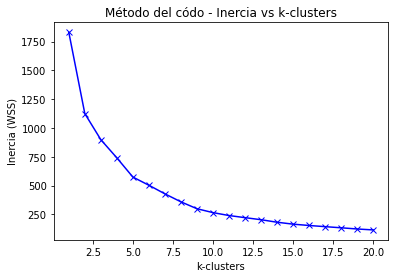

In [ ]:
plt.plot(range(1,21),WSS,'-bx')
plt.title('Método del códo - Inercia vs k-clusters')
plt.xlabel('k-clusters')
plt.ylabel('Inercia (WSS)')
plt.style.use('ggplot')
plt.show()

Podemos concluir de este método, que el número k de clústers óptimo para el dataset es de **$k = 2$**.

### 3.2 Búsqueda óptima de clusters a través del método de Calinski y Harabasz index.

Este método, nos entrega un indice para k-clusters en donde relaciona la dispersión a nivel intercluster (SSW) e intracluster (SSB) de la siguiente manera:

$$CH_{index} = \dfrac{SSB/(k-1)}{SSW/(n-k)},$$

donde $n$ es la cantidad de filas del dataset y $k$ la cantidad de clústers medidos. Utilizaremos el package de sckit-learn para definir este indice para cada $k$ partición.

In [ ]:
# Calcularemos el index para una cantidad k = 10 de clústers y compararemos en un gráfico.

from sklearn.metrics import calinski_harabasz_score

CH_index = []

for i in range(2,21):
    kmeans = KMeans(n_clusters = i, max_iter = 300, random_state = 1).fit(titanic_dev_norm)
    labels = kmeans.labels_
    CH_index.append(calinski_harabasz_score(titanic_dev_norm, labels))

Revisaremos como se ve el gráfico de CH_index versus el número de clusters.

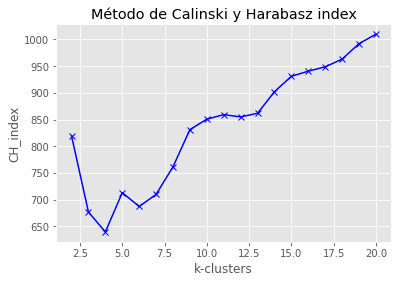

In [ ]:
plt.plot(range(2,21),CH_index,'-bx')
plt.title('Método de Calinski y Harabasz index')
plt.xlabel('k-clusters')
plt.ylabel('CH_index')
plt.style.use('ggplot')
plt.show()

Este método nos vuelve a confirmar que el número k de clústers óptimo para el dataset es de **$k = 2$**, dado que tiene el mayor $CH_{index} \approx 830$. De todas maneras, para salir de dudas utilizaremos la paquetería de **yellowbrick** que nos entrega directamente el valor k óptimo del indice de Calinski Harabasz.

In [ ]:
# Calinski Harabasz Score for K means
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(titanic_dev_norm)
visualizer.show()

YellowbrickValueError: ignored

Volvemos a confirmar que para $k = 2$ esta el punto óptimo de clusters para segmentar.

### 3.3 Análisis de centroides.

Ahora, que sabemos el k óptimo para segmentar, realizaremos el modelo KMeans para segmentar con $k = 2$.

In [ ]:
titanic_kmeans = KMeans(n_clusters = 2, max_iter = 300, random_state = 1).fit(titanic_dev_norm)

In [ ]:
tit_centroides = titanic_kmeans.cluster_centers_
tit_centroides_df = pd.DataFrame(tit_centroides)
tit_centroides_df.columns = titanic_dev_norm.columns
tit_centroides_df

,pass_class,sex,age,no_sib_spo_ob,no_par_chld_ob,pass_fare,survived,bool_life_boat,Cherbourg,Other,Queenstown,Southampton
0,0.751861,0.844913,0.384960,0.065292,0.036669,0.045431,0.997519,0.007444,0.146402,2.059984e-17,0.099256,0.754342
1,0.478044,0.321357,0.356323,0.057884,0.052783,0.096567,0.005988,0.958084,0.303393,3.992016e-03,0.083832,0.608782


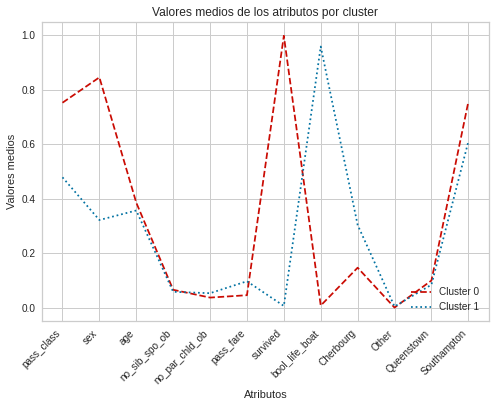

In [ ]:
plt.plot(tit_centroides_df.columns, tit_centroides[0], 'r', linestyle='--', label='Cluster 0')
plt.plot(tit_centroides_df.columns, tit_centroides[1], 'b', linestyle=':', label='Cluster 1')
plt.legend(loc = 'lower right')
plt.title('Valores medios de los atributos por cluster')
plt.xlabel('Atributos')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Valores medios')
plt.show()

De la gráfica de centroides podemos apreciar lo siguiente de los 2 clusters:

   1. **Cluster 0:** Esta conformado de personas de *tercera clase*, generalmente *hombres*, de distintas edades, que *no sobrevivieron*, y por lo tanto *no se encontraban en un bote salvavidas*, que en gran parte embarcaron en el puerto de *Southampton*.
   2. **Cluster 1:** Esta conformado de personas de *segunda y primera clase*, generalmente *mujeres*, de distintas edades, que *sobrevivieron*, y que gran parte *se encontraban en un bote salvavidas*, que en gran parte embarcaron en los puertos de *Shouthampton y Cherbourg*.

#### 3.3.1 PCA para visualización de los clusters.

Dado que estamos segmentando con mas de dos variables el dataset, se hace difícil poder ver visualmente la separación de los clústers desarrollaods, por lo que usaremos una metodología llamada **Análisis de Componentes Principales (PCA)**, para encontrar las 2 componentes principales del dataset para viusalizar gráficamente como se encuentran nuestros clústers.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(titanic_dev_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [ ]:
cluster = 'Cluster ' + pd.DataFrame(titanic_kmeans.labels_).astype(str)
cluster.columns = ['cluster']

tit_pca = pd.concat([principalDf, cluster], axis = 1)
tit_pca.head()

,PC1,PC2,cluster
0,1.049147,-0.662727,Cluster 1
1,0.633265,-0.502433,Cluster 1
2,-0.113844,-0.302162,Cluster 0
3,-0.530256,-0.102981,Cluster 0
4,-0.115232,-0.290302,Cluster 0


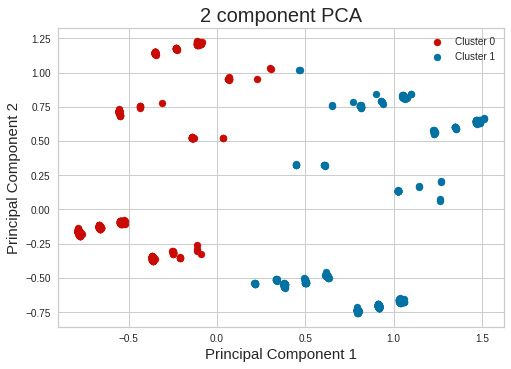

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
clusters = ['Cluster 0', 'Cluster 1']
colors = ['r', 'b']
for cluster, color in zip(clusters,colors):
    indicesToKeep = tit_pca['cluster'] == cluster
    ax.scatter(tit_pca.loc[indicesToKeep, 'PC1']
               , tit_pca.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(clusters)

### 3.4 Visualización en 2 dimensiones.

Revisaremos tambien como quedan nuestra segmentación para 2 dimensiones.

In [ ]:
tit_labels = titanic_kmeans.labels_
colours = ['red','blue']
asignar = []

for i in tit_labels:
    asignar.append(colours[i])

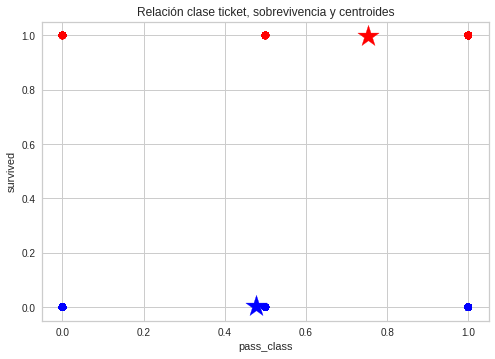

In [ ]:
plt.scatter(titanic_dev_norm['pass_class'],titanic_dev_norm['survived'], c = asignar)
plt.title('Relación clase ticket, sobrevivencia y centroides')
plt.xlabel('pass_class')
plt.ylabel('survived')

plt.scatter(tit_centroides[0,0], tit_centroides[0,6], marker = '*', c = 'red', s = 500)
plt.scatter(tit_centroides[1,0], tit_centroides[1,6], marker = '*', c = 'blue', s = 500)

plt.show()

### 3.5 Visualización en 3 dimensiones.

Revisaremos tambien como quedan nuestra segmentación para 3 dimensiones.

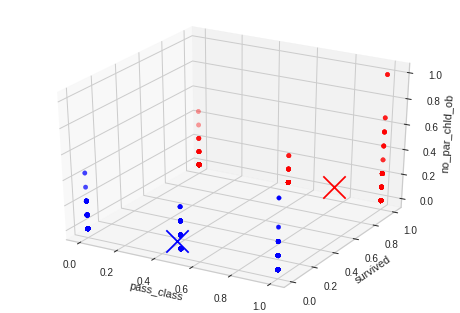

In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')

ax.scatter(titanic_dev_norm['pass_class'],titanic_dev_norm['survived'], titanic_dev_norm['no_par_chld_ob'], c = asignar, marker = 'o')
ax.set_xlabel('pass_class')
ax.set_ylabel('survived')
ax.set_zlabel('no_par_chld_ob')
ax.scatter(tit_centroides[0,0], tit_centroides[0,6], tit_centroides[0,4], marker = 'x', c = 'red', s = 500)
ax.scatter(tit_centroides[1,0], tit_centroides[1,6], tit_centroides[1,4], marker = 'x', c = 'blue', s = 500)
